# Generative Adversarial Networks (GANs)

## Initial Setup and Imports

In [39]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'inferno'

# Functions for plotting and training
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])
    print(images.shape[0])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    print(sqrtn)
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    print(sqrtimg)

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def img_show():
    config = tf.ConfigProto()
    show = tf.Session(config=config)
    return show

## Loading Dataset (MNIST data)
For simplicity and computational convenience, we use the MNIST dataset. This dataset contains real handwritten digits and 70,000 images of handwritten digits compiled by the U.S. National Institute of Standards and Technology from Census Bureau employees and high school students. Each picture contains a centered image of white digit on black background (0 through 9). 

In [ ]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

# show a batchleaky_relu
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

## Activation Function
We implement below the neural network function. To avoid potential issues from ReLU, we will implement Leaky ReLU.

In [ ]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    Output:
    - y: a TensorFlow Tensor with the same shape as x
    """
    return tf.nn.leaky_relu(x, alpha=alpha)

## Random Noise
In the cell below, we will generate a random uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [ ]:
def random_noise(batch_size, dim):
    """
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    Output:
    - noise: a TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # noise = tf.random.normal(shape=[batch_size, dim], mean=0.0, stddev=1.0) # random gaussian
    noise = tf.random.uniform(shape=[batch_size, dim], minval=-1, maxval=1) # random uniform
    return noise

## Discriminator
First, we will implement the first neural network, the discriminator. To build the model, we will use the layers in `tf.layers`. The architecture we adopt is as follows:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and should contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [ ]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    Input:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    Output:
    - logits: a TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):

        l1 = tf.layers.dense(x, 256, activation=leaky_relu)
        l2 = tf.layers.dense(l1, 256, activation=leaky_relu)
        logits = tf.layers.dense(l2, 1, activation='sigmoid')

    return logits

## Generator
Second, we will build the generator in a similar way as the discriminator. The architecure we adopt is:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * Tanh 

In [ ]:
def generator(z):
    """Generate images from a random noise vector.
    Input:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    Output:
    - img: a TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        
        l1_b = tf.layers.dense(z, 1024, activation='relu')
        l2_b = tf.layers.dense(l1_b, 1024, activation='relu')
        img = tf.layers.dense(l2_b, 784, activation='tanh')
        
    return img

# GAN Loss

We will implement below the loss of the GAN. 

The generator loss is:

$$\mathcal{L}_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

The discriminator loss is:

$$\mathcal{L}_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

For computing the loss function, we will use the sigmoid cross entropy loss.

In [ ]:
def gan_loss(logits_real, logits_fake):
    """
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Outputs:
    - D_loss: discriminator loss [scalar]
    - G_loss: generator loss [scalar]
    """
    G_loss = -tf.reduce_mean(tf.log(logits_fake))
    D_loss = - tf.reduce_mean(tf.log(logits_real)) - tf.reduce_mean(tf.log(tf.math.subtract(tf.ones_like(logits_fake),logits_fake)))
    
    return D_loss, G_loss

# Optimizer
For the loss optimization, we will implement an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. If you want to see a 'pathological' mode in GANs, you can beta1=0.9. That way, the discriminator loss might go to zero (i.e., learns too fast) and the generator might fail completely to learn. 
You can also experiment with other optimizers (e.g., SGD with Momentum or RMSProp). 

In [8]:
def gan_optimizers(learning_rate=1e-3, beta1=0.5):
    """Create optimizers for GAN training.
    Inputs:
    - learning_rate: learning rate to use for both optimizers
    - beta1: beta parameter for both optimizers (first moment decay)
    
    Outputs:
    - D_opt: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_opt: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_opt, G_opt

## GAN Composition
In the below cell, we compose the generator and discriminator by using the previous functions

In [9]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# random noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = random_noise(batch_size, noise_dim)
# generated images

G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(2 * x - 1.0)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_opt, G_opt = gan_optimizers()

# get our loss

D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_opt.minimize(D_loss, var_list=D_vars)
G_train_step = G_opt.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

<ipython-input-6-5db958fc908a>:12: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  l1_b = tf.layers.dense(z, 1024, activation='relu')
C:\Users\mahau\AppData\Roaming\Python\Python39\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
<ipython-input-6-5db958fc908a>:13: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  l2_b = tf.layers.dense(l1_b, 1024, activation='relu')
<ipython-input-6-5db958fc908a>:14: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  img = tf.layers.dense(l2_b, 784, activation='tanh')


# GAN training
We use a simple procedure. We train D(x) and G(z) with one batch each every iteration.

In [12]:
# the main function to train a GAN

def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,
              show_every=2, print_every=1, batch_size=128, num_epoch=20):
    """Train a GAN for a certain number of epochs.
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    """
    # compute the number of iterations needed
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    for epoch in range(num_epoch):
        # show a sample result
        if epoch % show_every == 0:
            samples = sess.run(G_sample)
            print(len(samples[:16]))
            print(len(samples[:16][0]))
            print(type(samples[:16]))
            fig = show_images(samples[:16])
            plt.show()
            print()
        for (minibatch, minbatch_y) in mnist:
            # run a batch of data through the network
            _, D_loss_curr = sess.run(
                [D_train_step, D_loss], feed_dict={x: minibatch})
            _, G_loss_curr = sess.run([G_train_step, G_loss])

        # We want to make sure D_loss doesn't go to 0
        if epoch % print_every == 0:
            print('Epoch: {}, D: {:.4}, G:{:.4}'.format(
                epoch, D_loss_curr, G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

16
784


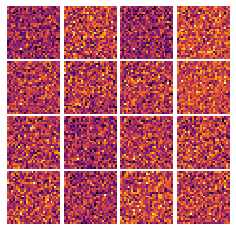


Epoch: 0, D: 1.57, G:0.422
Epoch: 1, D: 1.282, G:1.187
16
784


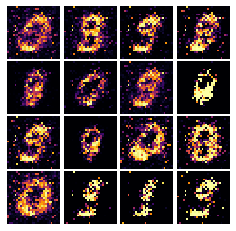


Epoch: 2, D: 1.206, G:1.027
Epoch: 3, D: 1.507, G:0.874
16
784


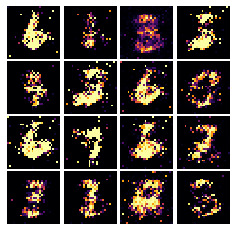


Epoch: 4, D: 1.393, G:0.7748
Epoch: 5, D: 1.334, G:0.8142
16
784


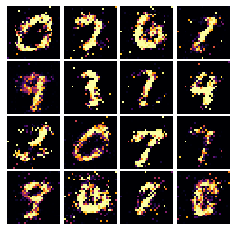


Epoch: 6, D: 1.383, G:0.9605
Epoch: 7, D: 1.385, G:0.7553
16
784


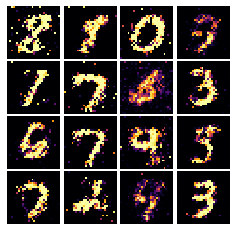


Epoch: 8, D: 1.463, G:0.7475
Epoch: 9, D: 1.269, G:0.9545
16
784


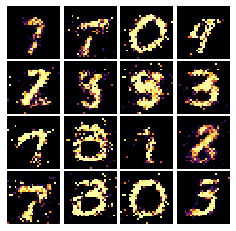


Epoch: 10, D: 1.406, G:0.8786
Epoch: 11, D: 1.377, G:0.7866
16
784


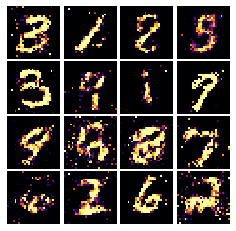


Epoch: 12, D: 1.309, G:0.8203
Epoch: 13, D: 1.394, G:0.8207
16
784


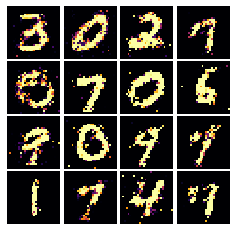


Epoch: 14, D: 1.345, G:0.6383
Epoch: 15, D: 1.39, G:0.7818
16
784


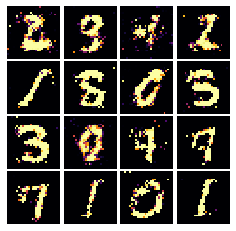


Epoch: 16, D: 1.35, G:0.827
Epoch: 17, D: 1.242, G:0.8688
16
784


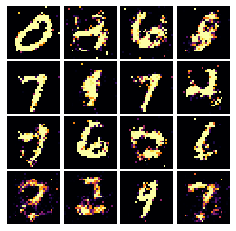


Epoch: 18, D: 1.288, G:0.9096
Epoch: 19, D: 1.388, G:0.744
Final images


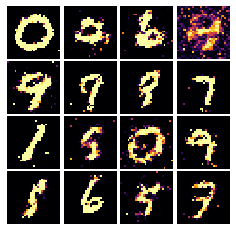

In [11]:
with img_show() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step,
              D_loss, G_extra_step, D_extra_step)

# GAN2: Changing the loss function and the divergence 
We will now implement a GAN with a different loss function. Specifically, we will implement the following objective functions for 
the generator loss:
$$\mathcal{L}_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \mathcal{L}_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$
This GAN variant is known as Least Squares GAN, which substitutes the binary cross entropy loss with a least square ($\ell_2$) loss, which has better properties for optimization and is less likely to saturate. It has been shown that minimizing the above objective functions yields minimizing the Pearson $\chi^2$ divergence.

In [12]:
def gan2_loss(score_real, score_fake):
    """
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
    
    Outputs:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    G_loss = 0.5*tf.reduce_mean(tf.math.square(tf.math.subtract(score_fake, tf.ones_like(score_fake))))
    D_loss = 0.5*tf.reduce_mean(tf.math.square(tf.math.subtract(score_real, tf.ones_like(score_real))))+0.5*tf.reduce_mean(tf.math.square(score_fake))
    
    return D_loss, G_loss

In [13]:
D_loss, G_loss = gan2_loss(logits_real, logits_fake)
D_train_step = D_opt.minimize(D_loss, var_list=D_vars)
G_train_step = G_opt.minimize(G_loss, var_list=G_vars)

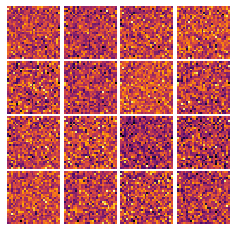


Epoch: 0, D: 0.2049, G:0.2544
Epoch: 1, D: 0.184, G:0.3174


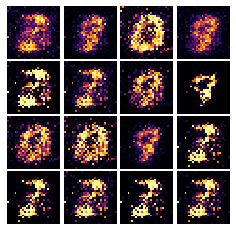


Epoch: 2, D: 0.253, G:0.2789
Epoch: 3, D: 0.2481, G:0.1897


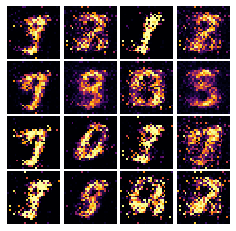


Epoch: 4, D: 0.2363, G:0.149
Epoch: 5, D: 0.2686, G:0.1658


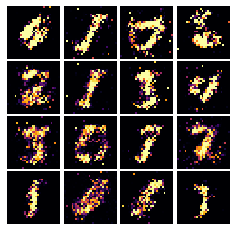


Epoch: 6, D: 0.2502, G:0.1801
Epoch: 7, D: 0.2243, G:0.1516


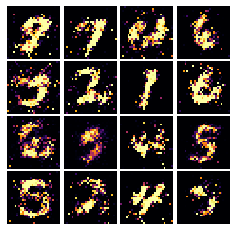


Epoch: 8, D: 0.2334, G:0.1618
Epoch: 9, D: 0.2012, G:0.173


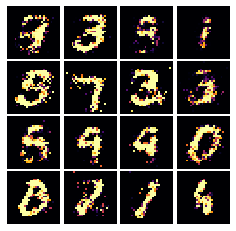


Epoch: 10, D: 0.2378, G:0.126
Epoch: 11, D: 0.2533, G:0.1522


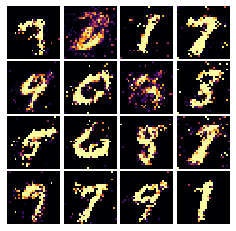


Epoch: 12, D: 0.21, G:0.152
Epoch: 13, D: 0.2329, G:0.1047


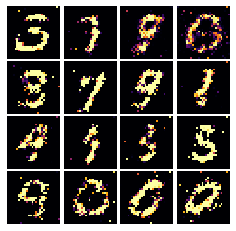


Epoch: 14, D: 0.2467, G:0.1443
Epoch: 15, D: 0.2474, G:0.1511


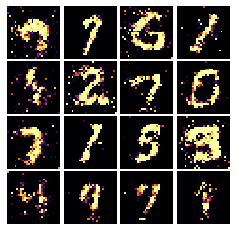


Epoch: 16, D: 0.2456, G:0.1199
Epoch: 17, D: 0.2185, G:0.1381


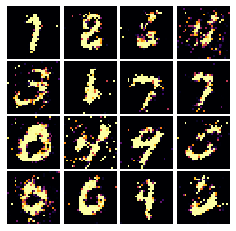


Epoch: 18, D: 0.2263, G:0.1773
Epoch: 19, D: 0.2145, G:0.1321
Final images


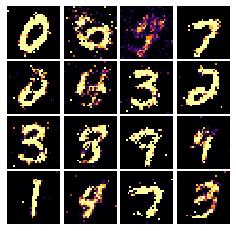

In [14]:
with img_show() as ses:
    ses.run(tf.global_variables_initializer())
    run_a_gan(ses, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# Qualitative Results:

- At each training, the first figure is just noise. Thus, we don't see anything but purple and yellow pixels. 
- From the second figure (epoch 1), we begin to distinguish white shapes on a black background. Some of them could be interpreted as numbers but most of them couldn't. A lot of purple pixels remain. There is a blur effect.
- As the number of epochs increase we can distinguish more precisely numbers between 0 and 9. From epoch 11, most of numbers are interpretables.
- The numbers created are different from those of the MNIST data. This is good as we wanted to create new images.
- The losses (D2 and G2) of the second GAN are more stable than the losses of the first GAN as we see on the plot below.
- The results don't change over different training runs, they quite stay the same. Of course, the samples are different as they come initialy from random noise and as we have a "creator" of samples. However, the visual quality of the samples over different training runs stay the same and the performance (assessed with losses) stay quite the same too.


Gaussian Noise:

- Visualy, first epochs with gaussian random noise are more centered (= white circles in the middle) than uniform noise.
- The final image is better in the case of a uniform noise than in the case of a gaussian noise.
- The losses (as we can see on the figures below) are quite the same for the two kind of noises (D compared to D1-gaussian and G compared to G1-gaussian).
- In fact, the losses are quite constant over epochs. D losses are more stable than G losses (more oscillations there).